<a href="https://colab.research.google.com/github/gc2321/3546-Deep-Learning/blob/main/gan/inda_gan_train_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Conv2DTranspose, LeakyReLU, Conv2D, Dropout, Flatten, Input
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
filePath ="/content/gdrive/MyDrive/neural_data/CDF-INDA.zip"
extractPath = "/content/dataset"

In [13]:
import zipfile

zip_ref = zipfile.ZipFile(filePath, 'r')
zip_ref.extractall(extractPath)
zip_ref.close()

In [26]:
import os
# List the files in the extracted directory
image_files = [f for f in os.listdir(extractPath + "/CDF-INDA") if os.path.isfile(os.path.join(extractPath  + "/CDF-INDA", f))]

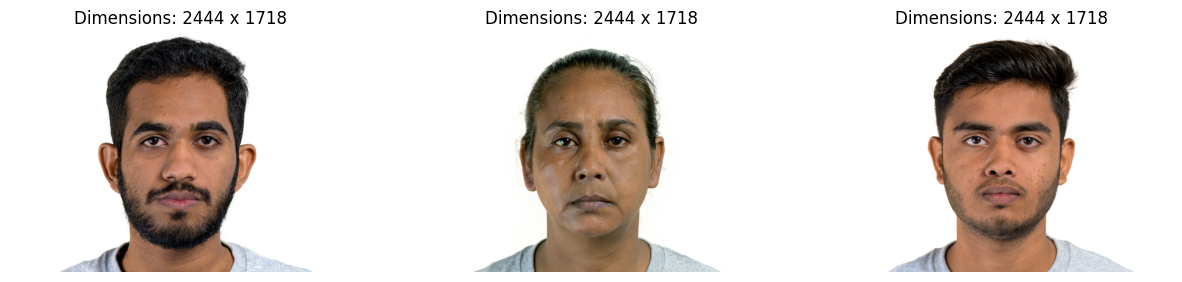

In [29]:
from PIL import Image
# Load the first 3 images
images = []
image_dims = []
for i in range(min(3, len(image_files))):
    img_path = os.path.join(extractPath + "/CDF-INDA", image_files[i])
    img = Image.open(img_path)
    images.append(img)
    image_dims.append(img.size)  # (width, height)

# Plot the first 3 images with their dimensions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, img, dim in zip(axes, images, image_dims):
    ax.imshow(img)
    ax.set_title(f'Dimensions: {dim[0]} x {dim[1]}')
    ax.axis('off')

plt.show()

In [33]:
# Define the path to the extracted data
data_path = "/content/dataset/"

# Define data generator for custom data
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=(172, 244),
    batch_size=32,
    class_mode=None  # No labels required for GANs
)

Found 138 images belonging to 1 classes.


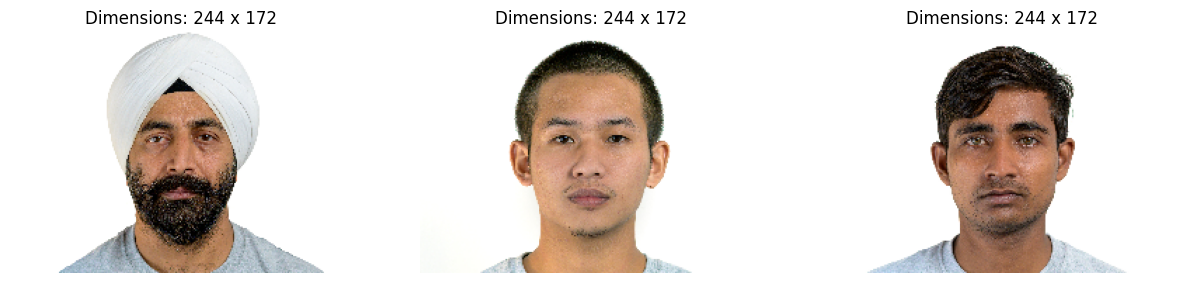

In [35]:
# Get the first batch of images
images_batch = next(train_generator)
first_three_images = images_batch[:3]

# Plot the first 3 images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, img in zip(axes, first_three_images):
    ax.imshow(img)
    ax.set_title(f'Dimensions: 244 x 172')
    ax.axis('off')

plt.show()


In [ ]:
# Define GAN architecture

# Generator model
def build_generator():
    model = Sequential()
    model.add(Dense(256 * 28 * 28, activation='relu', input_dim=100))
    model.add(Reshape((28, 28, 256)))
    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='tanh'))
    return model

In [ ]:
# Discriminator model
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(224, 224, 3)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model


In [ ]:
# Load real images
def load_data(generator, batch_size):
    data = []
    for _ in range(batch_size):
        img = next(generator)
        data.append(img)
    return np.array(data).squeeze()

In [ ]:
# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Build the generator
generator = build_generator()

# GAN model (stacked generator and discriminator)
z = Input(shape=(100,))
img = generator(z)
discriminator.trainable = False
validity = discriminator(img)
gan = Model(z, validity)
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

In [ ]:
# Training parameters
epochs = 10000
batch_size = 32
save_interval = 200

In [ ]:
# Load custom data
def load_data(generator, batch_size):
    X = []
    for _ in range(batch_size):
        img = generator.next()
        X.append(img[0])
    X = np.array(X)
    return X

In [ ]:
# Save generated images
def save_images(epoch, generator, examples=5, dim=(1, 5), figsize=(10, 10)):
    noise = np.random.normal(0, 1, (examples, 100))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5  # Rescale images 0 - 1
    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'gan_generated_image_epoch_{epoch}.png')
    plt.close()

In [ ]:
# Training loop
for epoch in range(epochs):
    # Train Discriminator
    imgs = load_data(train_generator, batch_size)
    noise = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(noise)

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    g_loss = gan.train_on_batch(noise, valid)

    # Print progress
    print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

    # If at save interval, save generated image samples
    if epoch % save_interval == 0:
        save_images(epoch, generator, examples=5)

print("Training completed.")

1/1 [==============================] - 3s 3s/step
0 [D loss: 0.7360157370567322 | D accuracy: 4.6875] [G loss: 0.6942514181137085]
1/1 [==============================] - 0s 16ms/step
1 [D loss: 0.349317068583332 | D accuracy: 50.0] [G loss: 0.6995063424110413]
